In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os

import multiprocessing
import re
from rdkit.Chem import rdchem

from subprocess import check_output

import hashlib
import pandas as pd

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network')
import build_tools as wt


# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/blink')

import blink

import requests
import json
from rdkit.Chem import MolFromSmiles, MolToInchiKey
from pyteomics import mgf
import networkx as nx
import matplotlib.pyplot as plt



# Set the display width for pandas columns
pd.set_option('display.max_colwidth', None)
# show more pandas columns
pd.set_option('display.max_columns', 500)


In [2]:
# metadata_folder = '/global/cfs/cdirs/metatlas/projects/carbon_network'
# ming_df = pd.read_csv(os.path.join(metadata_folder,'all_nonredundant_mri.tsv'),sep='\t')
# ming_df.head()
# my_id = 'MSV000087545'
# my_str = 'ccms_peak/TB1-5.'
# my_slice = ming_df[(ming_df['dataset'] == my_id) & (ming_df['filepath'].str.contains(my_str))]
# my_slice

In [3]:
metadata_folder = '/global/cfs/cdirs/metatlas/projects/carbon_network'

files_that_pass = pd.read_csv(os.path.join(metadata_folder,'files_that_pass_quality_control.csv'))
files_that_pass['parquet'] = files_that_pass['mzml'].str.replace('.mzML','.parquet',regex=False)
files_that_pass['massive_basename'] = files_that_pass['massive_basename'].str.replace('.mzML','',regex=False)
print(files_that_pass.shape)
files_that_pass.head()

(1324, 13)


,mzml,massive_id,h5,parquet,massive_basename,has_ccms_peak,has_neg_ms2,has_pos_ms2,hash_value,num_formula,num_formula_in_fticr,fraction_in_fticr,median_mass_error
0,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301373_JF_TREC_SW_SPE_DOM_RSC_LSI_02_PPL_3_Neg.mzML,MSV000092604,True,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301373_JF_TREC_SW_SPE_DOM_RSC_LSI_02_PPL_3_Neg.parquet,MSV000092604-MGC2301373_JF_TREC_SW_SPE_DOM_RSC_LSI_02_PPL_3_Neg,False,True,False,55621228863683605535014248509871470173529952476246208723193263343906524956138,667,586,0.878561,0.000331
1,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301368_JF_TREC_SW_SPE_DOM_RSC_LSI_01_PPL_2_Neg.mzML,MSV000092604,True,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301368_JF_TREC_SW_SPE_DOM_RSC_LSI_01_PPL_2_Neg.parquet,MSV000092604-MGC2301368_JF_TREC_SW_SPE_DOM_RSC_LSI_01_PPL_2_Neg,False,True,False,108960961530353880065149787330905062349780460956006942988038818532694755288083,637,557,0.874411,0.000297
2,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301299_JF_TARA_TREC_SPE_DOM_001_Z00_PPL2_Neg.mzML,MSV000092604,True,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301299_JF_TARA_TREC_SPE_DOM_001_Z00_PPL2_Neg.parquet,MSV000092604-MGC2301299_JF_TARA_TREC_SPE_DOM_001_Z00_PPL2_Neg,False,True,False,49713754048452711838853913476357151890821374426450984350739882468081435182207,852,727,0.853286,0.000307
3,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301309_JF_TARA_TREC_SPE_DOM_003_Z00_PPL_1_Neg.mzML,MSV000092604,True,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301309_JF_TARA_TREC_SPE_DOM_003_Z00_PPL_1_Neg.parquet,MSV000092604-MGC2301309_JF_TARA_TREC_SPE_DOM_003_Z00_PPL_1_Neg,False,True,False,83989522302755081459307920839877563847596244942656580684760903544732394379524,814,651,0.799754,0.000288
4,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301346_JF_TARA_TREC_SPE_DOM_010_Z00_PPL_Blank_Neg.mzML,MSV000092604,True,/pscratch/sd/b/bpb/massive/v06/MSV000092604/peak/mzml-neg/MGC2301346_JF_TARA_TREC_SPE_DOM_010_Z00_PPL_Blank_Neg.parquet,MSV000092604-MGC2301346_JF_TARA_TREC_SPE_DOM_010_Z00_PPL_Blank_Neg,False,True,False,106476028071529744395679434930593858312259528813641541708790561149592437203550,77,48,0.623377,0.000433


In [4]:
def get_files_from_disk(directory,extension):
    """
    Get on disk with date
    """
    get_with_date = ''.join(['find %s -iname "*%s"' % (directory,extension),' -printf "%Ts SplitThat%p\n"'])
    files = check_output(get_with_date, shell=True)
    files = files.decode('utf-8').splitlines()
    files = [f.split('SplitThat') for f in files]
    dates = [int(f[0].strip()) for f in files]
    files = [f[1].strip() for f in files]
    return dates,files

half_precursor_tolerance = 0.001 # since we typically use 0.002 as the precursor tolerance, we can use 0.001 as the half tolerance

data_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
environmental_metatlas_folder = os.path.join(data_dir,'metatlas')
# metatlas_no_buddy_folder = os.path.join(data_dir,'metatlas_no_buddy')


# Get metatlas-no-buddy  files
# dates, parquet_files = get_files_from_disk(metatlas_no_buddy_folder, 'parquet')
# dates, h5_files = get_files_from_disk(metatlas_no_buddy_folder, 'h5')

df = {}
# for f in parquet_files:
#     df[f.replace('.parquet','')] = {}
# for f in h5_files:
#     df[f.replace('.h5','')] = {}

# for f in parquet_files:
#     df[f.replace('.parquet','')]['parquet'] = f
# for f in h5_files:
#     df[f.replace('.h5','')]['h5'] = f

# Get metatlas environmental files
dates, parquet_files = get_files_from_disk(environmental_metatlas_folder, 'parquet')
dates, h5_files = get_files_from_disk(environmental_metatlas_folder, 'h5')

for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f

# get massive files
dates, parquet_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'parquet')
dates, h5_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'h5')
for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f


for k,v in df.items():
    if environmental_metatlas_folder in k:
        df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])

# for k,v in df.items():
#     if metatlas_no_buddy_folder in k:
#         df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])    

df = pd.DataFrame(df).T

# extract the massive ID from the path
pattern = r'(?<=/)(MSV.*?)(?=/)'
a = df.copy().index.str.extract(pattern)
df['massive_id'] = a[0].tolist()

# extract everything from the massive ID to the filename
pattern = r'(\/MSV.*)' 
df['redu_filename'] = df.copy().index.str.extract(pattern,expand=False)
df['redu_filename'] = df['redu_filename'].str.replace(r'^/', 'f.', regex=True)

# ADD IN EXPERIMENT_ID TO DEAL WITH BOTH MASSIVE AND LBL DATASETS
idx = pd.notna(df['massive_id'])
df.loc[idx,'experiment_id'] = df.loc[idx,'massive_id']

df.reset_index(inplace=True,drop=True)

df_grouped = df.groupby('experiment_id').size().reset_index(name='files_per_experiment')
df = pd.merge(df, df_grouped, on='experiment_id', how='left')

df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('.old.')]
df = df[~df['parquet'].str.contains('Frtlzr',case=False)]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df = df[~df['parquet'].str.contains('exctrl',case=False)]
df = df[(df['parquet'].str.contains('/raw_data/metatlas/',case=False)) | (df['parquet'].str.contains('/raw_data/massive/',case=False))]

df['massive_basename'] = df.apply(lambda x: '%s-%s'%(x['experiment_id'],os.path.basename(x['parquet'])),axis=1)
df['massive_basename'] = df['massive_basename'].str.replace('.parquet','',regex=False)
df['has_ccms_peak'] = df['parquet'].str.contains('ccms_peak',case=False)
df.sort_values('has_ccms_peak',ascending=False,inplace=True)
df.drop_duplicates('massive_basename',inplace=True)

df

,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,massive_basename,has_ccms_peak
9520,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000081120/ccms_peak/Stool_samples_ms2ldaPLUS/NEG_HILIC/CD_11_C_FrNEG.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000081120/ccms_peak/Stool_samples_ms2ldaPLUS/NEG_HILIC/CD_11_C_FrNEG.h5,MSV000081120,MSV000081120,f.MSV000081120/ccms_peak/Stool_samples_ms2ldaPLUS/NEG_HILIC/CD_11_C_FrNEG,21,MSV000081120-CD_11_C_FrNEG,True
11778,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466677Z01_E9_neg.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466677Z01_E9_neg.h5,MSV000085918,MSV000085918,f.MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466677Z01_E9_neg,149,MSV000085918-200728_LQ_PF0017796_466677Z01_E9_neg,True
11769,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466539Z01_F5_neg.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466539Z01_F5_neg.h5,MSV000085918,MSV000085918,f.MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466539Z01_F5_neg,149,MSV000085918-200728_LQ_PF0017796_466539Z01_F5_neg,True
11770,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466852Z01_A11_neg.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466852Z01_A11_neg.h5,MSV000085918,MSV000085918,f.MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466852Z01_A11_neg,149,MSV000085918-200728_LQ_PF0017796_466852Z01_A11_neg,True
11771,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466606Z01_H6_neg.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466606Z01_H6_neg.h5,MSV000085918,MSV000085918,f.MSV000085918/ccms_peak/PF017796_neg/200728_LQ_PF0017796_466606Z01_H6_neg,149,MSV000085918-200728_LQ_PF0017796_466606Z01_H6_neg,True
...,...,...,...,...,...,...,...,...
14260,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE15_505.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE15_505.h5,MSV000091754,MSV000091754,f.MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE15_505,121,MSV000091754-entact_RP_neg_CE15_505,False
14261,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE30_508.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE30_508.h5,MSV000091754,MSV000091754,f.MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE30_508,121,MSV000091754-entact_RP_neg_CE30_508,False
14262,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE90_508.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE90_508.h5,MSV000091754,MSV000091754,f.MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE90_508,121,MSV000091754-entact_RP_neg_CE90_508,False
14263,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_mzML/entact_RP_neg_CE75_499.parquet,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091754/peak/20190812_ENTACT_RP_

In [5]:
from metatlas.untargeted.tools import get_google_sheet
file_df = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1a')
print(df.shape)
df = df[df['parquet'].isin(file_df['parquet'])]
print(df.shape)

(12641, 8)
(1401, 8)


In [6]:

files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist()))

(1324, 436)

In [7]:
missing_files = list(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist()))
missing_files = files_that_pass[files_that_pass['massive_basename'].isin(missing_files)]
cfs_str = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/'
scratch_str = '/pscratch/sd/b/bpb/massive/'
for i,row in missing_files.iterrows():
    cfs_name = row['parquet'].replace(scratch_str,cfs_str)
    if not os.path.isfile(cfs_name):
        print(os.path.isfile(cfs_name),os.path.isfile(row['parquet']),cfs_name)

In [8]:
# files = df['parquet'].unique()
# files = [f for f in files if 'raw_data/metatlas/' in f]
# len(files)

In [9]:
set(file_df['parquet']) - set(df['parquet'].unique())

set()

In [10]:
set(df['parquet'].unique()) - set(file_df['parquet'])

set()

# merge massive metadata with all files

In [11]:
usecols = ['title','dataset','description','keywords','instrument']
massive_metadata = pd.read_csv(os.path.join(metadata_folder,'massive_metadata_2024.tsv'), sep='\t',usecols=usecols)
massive_metadata.columns = [c.lower() for c in massive_metadata.columns]
df = pd.merge(df,massive_metadata.add_suffix('_massive'),left_on='massive_id',right_on='dataset_massive',how='left')


# Merge REDU Information

In [12]:
# redu = pd.read_csv(os.path.join(metadata_folder,'all_sampleinformation.tsv'), sep='\t')
# redu['filename'] = redu['filename'].str.replace(r'\.mz(ML|XML)$', '', regex=True)
# redu.columns = [c.lower() for c in redu.columns]
# df = pd.merge(df,redu.add_suffix('_redu'),left_on='redu_filename',right_on='filename_redu',how='left')


# MERGE in Environmental Experiment List

In [13]:
environmental_metatlas_folder

'/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas'

In [14]:
dom_samples = pd.read_csv(os.path.join(metadata_folder,'dom_public_datasets.csv'),usecols=['dataset'])
dom_samples = pd.Series(dom_samples['dataset'].unique())
df['environmental'] = (df['massive_id'].isin(dom_samples)) | (df['parquet'].str.contains(environmental_metatlas_folder+'/'))
df.shape

(1401, 14)

In [15]:
files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist()))

(1324, 436)

# Identify Plant files for manuscript

In [16]:
# idx1 = df['sampletype_redu'].str.contains('plant',case=False,na=False)
# idx2 = df['parquet'].str.contains('20240409_EB_NB_107915-001_PRISM-RtExu_combined-rep1-5_EXP120A_C18-EP_USDAY72349')
# df['plant'] = (idx1) | (idx2)


In [17]:

# df[df['plant']].to_csv(os.path.join(metadata_folder,'plant_samples.csv'),index=False)
# df[df['plant']].to_csv('plant_samples.csv',index=False)

# Filter to either plant or environment

In [18]:
df = df[df['environmental']] #1506
df.shape,files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist()))

((1401, 14), 1324, 436)

# remove rows that do not have a parquet file

In [19]:
df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df.shape


(1401, 14)

# remove profile mode files

In [20]:
# out_diff = []
# for i,row in df.iterrows():
#     filename = row['h5']
#     data = pd.read_hdf(filename,'ms2_neg')
#     data = ft.group_duplicates(data,group_col='rt')
#     mz_diff = data['mz'].apply(lambda x: np.median(abs(np.diff(x))))
#     out_diff.append(mz_diff.median())
# out_diff

# remove duplicate files within massive IDs

# remove duplicate files

In [21]:


# def hash_dataframe_row(filename):
#     cols = ['precursor_mz']
#     try:
#         t = pd.read_parquet(filename)
#         for c in cols:
#             t[c] = t[c].round(4)
#         hash_value = int(hashlib.sha256(pd.util.hash_pandas_object(t[cols], index=True).values).hexdigest(), 16)
#         return hash_value
#     except:
#         print('Error',filename)
#         return None

# def parallel_hash_dataframe(files):
#     with multiprocessing.Pool(20) as pool:
#         results = pool.map(hash_dataframe_row, files)
#     return results

# hash_values = parallel_hash_dataframe(df['parquet'].tolist())
# df['hash_value'] = hash_values
# df.sort_values(['environmental','files_per_experiment'],ascending=False,inplace=True) # True is greater than False
# df.drop_duplicates(subset=['hash_value'],keep='first',inplace=True)
# print(df.shape[0],files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist())))

In [22]:
# use natural language processing to parse the column description_massive and categorize each row in df


# Load all MDM spectra and formula from the parquet files

In [23]:


def process_row(parquet_file):
    temp = pd.read_parquet(parquet_file)
    if temp.shape[0]>0:
        temp['parquet'] = parquet_file
        return temp
    



files = df[pd.notna(df['parquet'])]['parquet'].tolist()
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row, files)

all_mdm_df = [o for o in out if o is not None]
all_mdm_df = pd.concat(all_mdm_df)
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df = all_mdm_df[pd.notna(all_mdm_df['mdm_mz_vals'])] # 1132622, 833718
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df.index.name = 'original_index' # you need this later for looking at ms1 evidence
all_mdm_df.reset_index(inplace=True,drop=False)
all_mdm_df.shape

(693383, 13)

# Count the fraction of formulae observed in FTICR experiments

In [24]:
# def calculate_fraction_in_fticr(df,group_term='parquet'):
#     df = df[pd.notna(df['predicted_formula'])]
#     result_true = df[df['isin_fticr_formula'] == True].groupby(group_term)['predicted_formula'].nunique()
#     result_false = df[df['isin_fticr_formula'] == False].groupby(group_term)['predicted_formula'].nunique()
#     combined_result = pd.concat([result_true, result_false], axis=1)
#     combined_result.columns = ['formula_count_in_fticr', 'formula_count_not_in_fticr']

#     combined_result.fillna(0, inplace=True)
#     combined_result['fraction_formula_in_fticr'] = combined_result['formula_count_in_fticr'] / (combined_result['formula_count_in_fticr'] + combined_result['formula_count_not_in_fticr'])
#     combined_result.reset_index(inplace=True,drop=False)
    
#     return combined_result

# formula_df = pd.read_csv('/global/homes/b/bpb/repos/scndb/data/merged_fticr_formula (2).csv')
# formula_df.drop(columns=['Unnamed: 0'], inplace=True)
# # Add new columns for each unique value in "environment type"
# # cols = ['formula','environment_type']
# # formula_df = pd.pivot_table(formula_df[cols], index='formula', columns='environment_type', aggfunc=lambda x: True, fill_value=False)
# cols =  ['environment_type', 'extraction_solvent',
#        'ppl_extracted', 'instrument_type',
#        'mass_range', 'doi']
# for c in cols:
#     env = formula_df.groupby(['formula',c])['polarity'].count().unstack().fillna(0)
#     env[env>0] = 1
#     env.columns = ['%s:%s'%(c,x) for x in env.columns]
#     env = env.astype(int)
#     formula_df = formula_df.merge(env, left_on='formula', right_index=True)
#     formula_df.drop(columns=c, inplace=True)
#     print(c)
# formula_df.drop_duplicates(subset='formula', inplace=True)
# formula_df.reset_index(drop=True, inplace=True)

# formula_df.drop(columns=['mz','ionization_method','polarity'],inplace=True)
# all_mdm_df['isin_fticr_formula'] = all_mdm_df['predicted_formula'].isin(formula_df['formula'])

# fraction_in_fticr = calculate_fraction_in_fticr(all_mdm_df)

# df = pd.merge(df,fraction_in_fticr,on='parquet',how='left')
# v = all_mdm_df.groupby('parquet')['isin_fticr_formula'].mean().sort_values(ascending=True)

# import matplotlib.pyplot as plt
# fig,ax = plt.subplots()
# ax.hist(v,bins=100)


In [25]:
# print(all_mdm_df.shape,df.shape)
# all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(v[v>0.3].index.tolist())]
# df = df[df['parquet'].isin(all_mdm_df['parquet'].unique())]
# print(all_mdm_df.shape,df.shape)
# cols = ['formula_count_in_fticr','formula_count_not_in_fticr']
# files_no_formula = df.loc[df[cols].sum(axis=1)<10,'parquet'].tolist()
# df = df[~df['parquet'].isin(files_no_formula)]
# all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(df['parquet'].unique())]
# print(all_mdm_df.shape,df.shape)
# print(df.shape[0],files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist())))

# Get hits to MDM and original spectra

In [28]:
mz_tol = 0.002
# deltas = pd.read_csv(os.path.join(metadata_folder,'mdm_neutral_losses.csv'))
ref,ref2 = wt.get_p2d2(wt.mdm_df,mz_tol=mz_tol)
print(ref.shape)
ref.reset_index(inplace=True,drop=True)
ref2.reset_index(inplace=True,drop=True)
print(ref.shape)
ref_spec = ref['spectrum'].tolist()
ref_pmz = ref['precursor_mz'].tolist()

ref_spec_nl = ref2['nl_spectrum'].tolist()
ref_pmz_nl = ref2['precursor_mz'].tolist()

def score_df(df):
    min_matches=3,
    min_score=0.7,
    override_matches=20
    df.reset_index(inplace=True,drop=True)
    q_cols = ['predicted_formula','precursor_mz']
    r_cols = ['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']

    if df.shape[0]==0:
        return None
    if 'mdm_mz_vals' not in df.columns:
        return None
    df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x) if type(x)!=float else 0)

    df = df[df['num_mdm_frags']>0]


    df['mdm_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    df['original_spectrum'] = df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

    query_spec = df['original_spectrum'].tolist()
    query_pmz = df['precursor_mz'].tolist()
    query_spec_nl = df['mdm_spectrum'].tolist()
    query_pmz_nl = df['precursor_mz'].tolist()

    d_specs = blink.discretize_spectra(query_spec,  ref_spec, query_pmz, ref_pmz, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    d_specs_nl = blink.discretize_spectra(query_spec_nl,  ref_spec_nl, query_pmz_nl, ref_pmz_nl, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    
    def score_and_filter(specs,r,q,mz_tol=0.002,min_score=0.7,min_matches=3,override_matches=20,
                         q_cols=['predicted_formula','precursor_mz'],
                         r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']):
        scores = blink.score_sparse_spectra(specs)
        filtered_scores = blink.filter_hits(scores,min_score=min_score,min_matches=min_matches,override_matches=override_matches,)
        mz_df = blink.reformat_score_matrix(filtered_scores)
        mz_df = blink.make_output_df(mz_df)
        for c in mz_df.columns:
            mz_df[c] = mz_df[c].sparse.to_dense()

        mz_df = pd.merge(mz_df,q[q_cols],left_on='query',right_index=True)
        mz_df = pd.merge(mz_df,r[r_cols].add_suffix('_ref'),left_on='ref',right_index=True)
        # mz_df = mz_df[mz_df['predicted_formula']==mz_df['formula']]
        mz_df = mz_df[abs(mz_df['precursor_mz']-mz_df['precursor_mz_ref'])<mz_tol]
        # mz_df.sort_values('score',ascending=False,inplace=True)
        # mz_df.drop_duplicates('inchi_key_ref',keep='first',inplace=True)
        return mz_df
    orig_hits = score_and_filter(d_specs,ref,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    nl_hits = score_and_filter(d_specs_nl,ref2,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index_ref'],how='outer',suffixes=('_original','_mdm'))
    if temp.shape[0]==0:
        return None
    temp['max_score'] = temp[['score_original','score_mdm']].max(axis=1)
    temp['best_match_method'] = temp[['score_original','score_mdm']].idxmax(axis=1)
    temp.sort_values('max_score',ascending=False,inplace=True)
    temp = temp[temp['max_score']>min_score]  #filter on score
    temp['max_matches'] = 0
    idx = temp['best_match_method']=='score_original'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
    idx = temp['best_match_method']=='score_mdm'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_mdm']
    temp = temp[temp['max_matches']>=min_matches]  #filter on matches


    cols = ['score_original','matches_original', 'score_mdm', 'matches_mdm']
    temp.drop(columns=cols,inplace=True)
    temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

    idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
    temp = temp[~idx_isolated] #filter on isolated precursor

    cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
    temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index_ref',right_on='original_p2d2_index',how='left')

    idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
    temp = temp[idx_precursor] #filter on precursor m/z
    
    # temp.sort_values('max_score',ascending=False,inplace=True)
    # temp = temp.groupby('query').head(1)
    # temp.reset_index(inplace=True,drop=True)
    return temp


# split all_mdm_df into chunks that are roughly 1000 large
chunks = np.array_split(all_mdm_df, np.ceil(len(all_mdm_df) / 1000))

def process_row(chunk):
    temp = score_df(chunk)
    return temp
    

with multiprocessing.Pool(10) as pool:
    out = pool.map(process_row, chunks)

out = pd.concat(out)
out.to_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))


(25677, 9)
(25677, 9)


In [29]:




def calculate_mass(formula):
    # Regular expression to match elements and their counts
    pattern = r'([A-Z][a-z]*)(\d*)'    
    mass = 0
    pt = rdchem.GetPeriodicTable()

    for el, count in re.findall(pattern, formula):
        # If count is an empty string, it means there's only one atom of this element
        count = int(count) if count else 1
        mass += pt.GetMostCommonIsotopeMass(el) * count
    return mass

unique_formulas = all_mdm_df['predicted_formula'].unique()
masses = {f:calculate_mass(f) for f in unique_formulas}
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_formula'].map(masses)
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_mass'] - 1.007276
all_mdm_df['mass_error'] = abs(all_mdm_df['precursor_mz'] - all_mdm_df['predicted_mass'])




# there better be nothing to remove here

In [30]:
print(df.shape[0],files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(df['massive_basename'].tolist())))

1401 1324 436


In [31]:
all_mdm_df.groupby('parquet')['mass_error'].median().sort_values(ascending=False).head(10)


parquet
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_A5M_NEG_MSMS_rep3.parquet              0.000848
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_A5M_NEG_MSMS_rep1.parquet              0.000768
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000087572/ccms_peak/raw data/NEG_MSMS_raw/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep2.parquet    0.000723
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_M_NEG_MSMS_rep2.parquet                0.000717
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_A_NEG_MSMS_rep1.parquet                0.000704
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_pe

# Merge hdf5 filename with the parquet filenames in all_mdm_df

# copy any missing hdf5 files to where they are supposed to be

In [32]:
cols=['filename','parquet']
files_df = all_mdm_df[cols].copy()
files_df.drop_duplicates(inplace=True)
files_df.reset_index(drop=True,inplace=True)
files_df['h5_missing'] = [not os.path.exists(f.replace('.parquet','.h5')) for f in files_df['parquet']]
files_to_copy = files_df[files_df['h5_missing']].copy()
files_to_copy['original_h5_missing'] = [not os.path.exists(f) for f in files_to_copy['filename']]
print(sum(files_to_copy['original_h5_missing']))
for i,row in files_to_copy.iterrows():
    parquet_file = row['parquet']
    h5_file = parquet_file.replace('.parquet','.h5')
    source_file = row['filename']
    dest_file = h5_file
    print('Copying %s to %s'%(source_file,dest_file))
    os.system('cp "%s" "%s"'%(source_file,dest_file))

all_mdm_df['h5'] = [f.replace('.parquet','.h5') for f in all_mdm_df['parquet']]


0


# Calculate the MS1 evidence for the predicted precursor in the MDM spectra

In [33]:
# FILTER OUT ANY SPECTRA THAT DO NOT HAVE MS1 OR NOT CALIBRATED WELL


def calculate_ms1_summary(row):
    """
    Calculate summary properties for features from data
    """
    d = {}
    #Before doing this make sure "in_feature"==True has already occured
    d['num_datapoints'] = row['i'].count()
    if d['num_datapoints'] == 0:
        return pd.Series(d)
    d['peak_area'] = row['i'].sum()
    idx = row['i'].idxmax()
    d['peak_height'] = row.loc[idx,'i']
    d['mz_centroid'] = sum(row['i']*row['mz'])/d['peak_area']
    d['rt_peak'] = row.loc[idx,'rt']
    return pd.Series(d)

def make_atlas(df,ppm_tolerance = 5,mz_tol = 0.002,extra_rt=1):
    atlas = df.copy()
    atlas.rename(columns={'original_index':'label','rt':'rt_peak','precursor_mz':'mz'},inplace=True)
    atlas['rt_min'] = atlas['rt_peak'] - extra_rt
    atlas['rt_max'] = atlas['rt_peak'] + extra_rt
    atlas['mz_tolerance'] = mz_tol
    atlas['ppm_tolerance'] = ppm_tolerance
    atlas['extra_time'] = 0
    atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                        stepsize=ppm_tolerance,
                                        do_ppm=True)
    return atlas




def process_row(gg):
    filename = gg[0]
    atlas = make_atlas(gg[1])
    # try:
    d = ft.get_atlas_data_from_file(filename,atlas,desired_key='ms1_neg')
    # d = d[d['in_feature']==True]
    # except:
    #     print('Can not read',filename)
    d = d.groupby('label',group_keys=True).apply(calculate_ms1_summary)
    return d


cols = ['original_index','precursor_mz',  'rt']

g = [(_,gg[cols]) for _,gg in all_mdm_df[pd.notna(all_mdm_df['h5'])].groupby('h5')]    
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row,g)    
out = pd.concat(out)

cols = ['num_datapoints','peak_area','peak_height','mz_centroid','rt_peak']
out = out[cols]


# temp = pd.merge(out,all_df[cols],left_on='label',right_on='original_index',how='inner')
# temp['ppm_error'] = abs(temp['mz_centroid']-temp['precursor_mz']) / temp['precursor_mz'] * 1e6
# temp = temp[temp['ppm_error']<5]
# temp = temp[temp['num_datapoints']>5]
# # fig,ax = plt.subplots()
# # temp['num_datapoints'].apply(np.log10).hist(bins=100,ax=ax)


# all_df = all_df[all_df.index.isin(temp['label'])]

In [34]:
out.reset_index(inplace=True,drop=False)
out.shape

(648900, 6)

In [35]:
temp = pd.merge(out.add_suffix('_ms1'),all_mdm_df,left_on='label_ms1',right_on='original_index',how='right')
print(temp.shape[0])
temp = temp[temp['num_datapoints_ms1']>0]
temp = pd.merge(temp,df,left_on='parquet',right_on='parquet',how='left')
if 'hash_value' in temp.columns:
    temp.drop(columns=['hash_value'],inplace=True)
print(temp.shape[0])


693383
648900


In [1]:
648900/693383

0.9358464225399238

In [36]:
cols = ['formula_count_in_fticr','h5_x', 'h5_y','filename','redu_filename',
       'files_per_experiment', 'ms2_mz_vals',
       'ms2_i_vals','label_ms1','formula_count_in_fticr',
       'formula_count_not_in_fticr', 'fraction_formula_in_fticr']
cols = [c for c in cols if c in temp.columns]
temp.drop(columns=cols,inplace=True)
temp.to_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

In [37]:
mz_tol = 0.002
min_intensity_ratio = 2
similarity_cutoff = 0.8

# Export table of files used

In [38]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))
cols = ['parquet', 
       'experiment_id', 'massive_id',
       'title_massive', 'dataset_massive', 'description_massive',
       'instrument_massive', 'keywords_massive']

# 'filename_redu',
#        'attribute_datasetaccession_redu', 'sampletype_redu',
#        'sampletypesub1_redu', 'ncbitaxonomy_redu', 'ncbidivision_redu',
#        'ncbirank_redu', 'yearofanalysis_redu', 'uberonbodypartname_redu',
#        'biologicalsex_redu', 'ageinyears_redu', 'lifestage_redu',
#        'country_redu', 'healthstatus_redu', 'chromatographyandphase_redu',
#        'ionizationsourceandpolarity_redu', 'massspectrometer_redu',
#        'sampleextractionmethod_redu', 'samplecollectionmethod_redu',
#        'comorbiditylistdoidindex_redu', 'doidcommonname_redu',
#        'doidontologyindex_redu', 'envoenvironmentbiome_redu',
#        'depthoraltitudemeters_redu', 'humanpopulationdensity_redu',
#        'internalstandardsused_redu', 'latitudeandlongitude_redu',
#        'samplecollectiondateandtime_redu', 'envoenvironmentmaterial_redu',
#        'envoenvironmentbiomeindex_redu', 'envoenvironmentmaterialindex_redu',
#        'subjectidentifierasrecorded_redu', 'termsofposition_redu',
#        'uberonontologyindex_redu', 'uniquesubjectid_redu', 'usi_redu',
#        'datasource_redu'

all_spectra = all_spectra[cols]
all_spectra.drop_duplicates(subset='parquet',inplace=True)
all_spectra.reset_index(drop=True,inplace=True)
all_spectra['h5'] = [f.replace('.parquet','.h5') for f in all_spectra['parquet']]

all_spectra.to_csv(os.path.join(metadata_folder,'all_files_for_environetwork.csv'),index=False)

In [39]:
import pandas as pd
import os
metadata_folder = '/global/cfs/cdirs/metatlas/projects/carbon_network'
temp = pd.read_csv(os.path.join(metadata_folder,'all_files_for_environetwork.csv'))

temp

,parquet,experiment_id,massive_id,title_massive,dataset_massive,description_massive,instrument_massive,keywords_massive,h5
0,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_M_Neg_MS2_rep3.parquet,MSV000087995,MSV000087995,GNPS DOM Interlab-LCMS 2021 - lab 18,MSV000087995,Interlab study of marine dissolved organic matter and algal extracts 2021. lab 18,MS:1002877,DOM###Interlab LCMS,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_M_Neg_MS2_rep3.h5
1,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_M_Neg_MS2_rep1.parquet,MSV000087995,MSV000087995,GNPS DOM Interlab-LCMS 2021 - lab 18,MSV000087995,Interlab study of marine dissolved organic matter and algal extracts 2021. lab 18,MS:1002877,DOM###Interlab LCMS,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_M_Neg_MS2_rep1.h5
2,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A_Neg_MS2_rep1.parquet,MSV000087995,MSV000087995,GNPS DOM Interlab-LCMS 2021 - lab 18,MSV000087995,Interlab study of marine dissolved organic matter and algal extracts 2021. lab 18,MS:1002877,DOM###Interlab LCMS,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A_Neg_MS2_rep1.h5
3,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A45M_Neg_MS2_rep2.parquet,MSV000087995,MSV000087995,GNPS DOM Interlab-LCMS 2021 - lab 18,MSV000087995,Interlab study of marine dissolved organic matter and algal extracts 2021. lab 18,MS:1002877,DOM###Interlab LCMS,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A45M_Neg_MS2_rep2.h5
4,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A_Neg_MS2_rep3.parquet,MSV000087995,MSV000087995,GNPS DOM Interlab-LCMS 2021 - lab 18,MSV000087995,Interlab study of marine dissolved organic matter and algal extracts 2021. lab 18,MS:1002877,DOM###Interlab LCMS,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000087995/ccms_peak/RAW/raw_MS2_neg/DOM_Interlab-LCMS_Lab018_A_Neg_MS2_rep3.h5
...,...,...,...,...,...,...,...,...,...
1396,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091211/peak/MZml/NEG_28.parquet,MSV000091211,MSV000091211,20230206 - Lignin ligands-quinones-permafrost soil extracts,MSV000091211,It includes analysis of different types of organic carbon 1 Model ligands and complexes 2 Lignin degradation materials 3 Quinones and adducts from biochars 4 Extraction and porewater of permafrost soils across the gradients of palsa-bog-fens,MS:1002523,"lignin, organic ligands, quinones, permafrost organic carbon extraction, palsa, bog, fens, pore water",/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091211/peak/MZml/NEG_28.h5
1397,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v01/MSV000091211/peak/MZml/NEG_27.parquet,MSV000091211,MSV000091211,20230206 - Lignin ligands-quinones-permafrost soil extracts,MSV000091211,It includes analysis of different types of organic carbon 1 Model ligands and complexes 2 Lignin degradation materials 3 Quinones and adducts from biochars 4 Extraction and porewater of permafrost soils across the gradients of palsa-bog-fens,MS:1002523,"lignin, organic ligands, quinones, permafrost organic carbon extraction, palsa, bog, fens, pore water",/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/mass

In [40]:
temp = temp[pd.notna(temp['experiment_id'])]
sum(temp['experiment_id'].str.contains('MSV')),temp.shape[0]

(982, 1401)

In [41]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))

all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
all_spectra = pd.merge(all_spectra,all_hits[['inchi_key','max_score','original_index_query']].add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
all_spectra['max_score_identity'] = all_spectra['max_score_identity'].fillna(0)
all_spectra['inchi_key_identity'] = all_spectra['inchi_key_identity'].fillna('')
# chunk df into smaller dataframes using natural breaks in the precursor m/z greater than 0.01
all_spectra.sort_values('precursor_mz',inplace=True)
all_spectra['precursor_mz_group'] = ft.group_consecutive(all_spectra['precursor_mz'].values[:],stepsize=mz_tol,do_ppm=False)



In [42]:
all_spectra['num_mdm_frags'] = all_spectra['mdm_mz_vals'].apply(lambda x: len(x))

<Axes: >

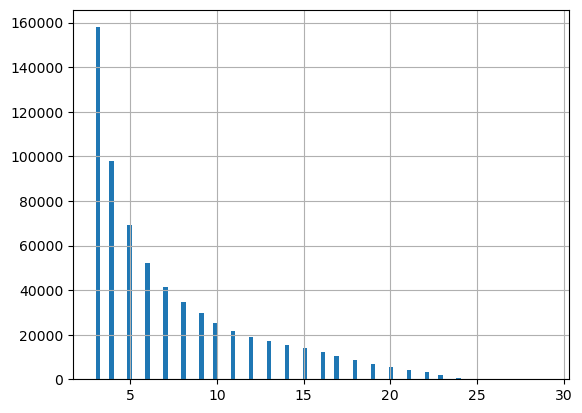

In [43]:
all_spectra['num_mdm_frags'].hist(bins=100)

In [44]:
print(all_spectra.shape[0],files_that_pass.shape[0],len(set(files_that_pass['massive_basename'].tolist()) - set(all_spectra['massive_basename'].tolist())))

648900 1324 436


# A  better way might be to start with the unique compound nodes and then add to them until you don't find any more unique!

In [45]:
import networkx as nx
def eliminate_duplicate_spectra(gg):
    ms2_df = gg[1]
    ms2_df['sum_frag_intensity'] = ms2_df['mdm_i_vals'].apply(lambda x: x.sum())
    ms2_df['max_score_identity'] = ms2_df['max_score_identity'].fillna(0)
    ms2_df['number_mdm_frags'] = ms2_df['mdm_mz_vals'].apply(lambda x: len(x))
    ms2_df.sort_values(['max_score_identity','sum_frag_intensity'],ascending=False,inplace=True) # 
    ms2_df.reset_index(inplace=True,drop=True)
    spec = ms2_df.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1).tolist()
    precursors = ms2_df['precursor_mz'].tolist()
    d_specs = blink.discretize_spectra(spec,  spec, precursors, precursors, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    scores = blink.score_sparse_spectra(d_specs)
    similarity_matrix = scores['mzi'].todense()
    # idx = np.triu_indices(similarity_matrix.shape[0],k=0)
    # similarity_matrix[idx] = 1000
    idx_ms2similarity = similarity_matrix>similarity_cutoff
    

    pmz_diff = abs(np.subtract.outer(ms2_df['precursor_mz'].values,ms2_df['precursor_mz'].values))
    # idx = np.triu_indices(pmz_diff.shape[0],k=0)
    # pmz_diff[idx] = 1000
    idx_pmz_same = pmz_diff<mz_tol
    
    conditions = (idx_pmz_same) & (idx_ms2similarity)
    r,c = np.argwhere(conditions).T
    idx = r<c
    r = r[idx]
    c = c[idx]
    if sum(idx)==0:
        return ms2_df
    G = nx.Graph()
    G.add_edges_from([(r[i],c[i]) for i in range(len(r))])
    # draw the graph colored by subgraphs layout using spring layout
    # df = pd.DataFrame({'source':source,'target':target})
    # add the subgraph number to the dataframe
    sub_graph_indices=list(nx.connected_components(G))
    sub_graph_indices = [(i, v) for i,d in enumerate(sub_graph_indices) for k, v in enumerate(d)]
    sub_graph_indices = pd.DataFrame(sub_graph_indices,columns=['spectrum_collection','id'])
    ms2_df = pd.merge(ms2_df,sub_graph_indices,left_index=True,right_on='id',how='inner')
    ms2_df.sort_values(['max_score_identity','number_mdm_frags','sum_frag_intensity'],ascending=False,inplace=True)

    # ms2_df.drop_duplicates(['spectrum_collection','inchi_key_identity'],keep='first',inplace=True)
    ms2_df.drop_duplicates(['spectrum_collection'],keep='first',inplace=True)

    return ms2_df
    
# def eliminate_duplicate_spectra(ms2_df,preserve_unique_iks=True):
#     ms2_df['sum_frag_intensity'] = ms2_df['mdm_i_vals'].apply(lambda x: x.sum())
#     ms2_df['max_score_identity'] = ms2_df['max_score_identity'].fillna(0)
#     ms2_df.sort_values(['max_score_identity','sum_frag_intensity'],ascending=False,inplace=True) # 
#     ms2_df.reset_index(inplace=True,drop=True)
#     spec = ms2_df.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1).tolist()
#     precursors = ms2_df['precursor_mz'].tolist()
#     d_specs = blink.discretize_spectra(spec,  spec, precursors, precursors, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
#     scores = blink.score_sparse_spectra(d_specs)
#     similarity_matrix = scores['mzi'].todense()
    
#     iks = ms2_df['inchi_key_identity'].values
#     idx_ik_same = iks[:,None] == iks
#     # idx_ik_same = idx_ik_same.astype(int)

#     has_ik = iks!=''
#     idx_has_ik = has_ik[:,None] != has_ik

#     # idx_ik_same = idx_ik_same | idx_no_ik
#     idx_ik_same_or_dominant = idx_ik_same | idx_has_ik

#     pmz_diff = abs(np.subtract.outer(ms2_df['precursor_mz'].values,ms2_df['precursor_mz'].values))
#     idx = np.triu_indices(pmz_diff.shape[0],k=0)
#     pmz_diff[idx] = 1000
    
#     frag_intensity = ms2_df['sum_frag_intensity'].values
#     intensity_diff = -1*np.subtract.outer(frag_intensity,frag_intensity)
#     intensity_diff = intensity_diff / frag_intensity[:,None]
#     idx_pmz_same = pmz_diff<mz_tol
#     idx_intensity_greater = intensity_diff>min_intensity_ratio
#     idx_ms2similarity = similarity_matrix>similarity_cutoff
    
#     # if preserve_unique_iks==True:
#     #     conditions = (idx_pmz_same) & ((idx_intensity_greater) | (idx_ms2similarity)) & (idx_ik_same_or_dominant)
#     # else:
#     # conditions = (idx_pmz_same) & ((idx_intensity_greater) | (idx_ms2similarity))
#     conditions = (idx_pmz_same) & (idx_ms2similarity)
#     r,c = np.argwhere(conditions).T
#     ms2_df = ms2_df[~ms2_df.index.isin(r)]
#     return ms2_df

# def process_row(gg):
#     return eliminate_duplicate_spectra(gg[1])

cols = ['precursor_mz','predicted_formula','original_index','mdm_mz_vals','mdm_i_vals','inchi_key_identity','max_score_identity','precursor_mz_group']
g = [(_,gg[cols]) for _,gg in all_spectra.groupby('precursor_mz_group')]
with multiprocessing.Pool(20) as pool:
    out = pool.map(eliminate_duplicate_spectra,g)
out = pd.concat(out)
idx1 = all_spectra['original_index'].isin(out['original_index'])

# # make sure to get all the spectra that have identity matches to every unique inchi key
# all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquer'))
# all_hits.sort_values('max_score',ascending=False,inplace=True)
# all_hits.drop_duplicates('inchi_key',keep='first',inplace=True)
# idx2 = all_spectra['original_index'].isin(all_hits['original_index_query'])

node_data = all_spectra[idx1]
# node_data.drop_duplicates('original_index',inplace=True)
node_data.shape

(16372, 34)

# merge in the top hit for each spectrum

In [46]:
all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))
all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
node_data.drop(columns=['inchi_key_identity','max_score_identity','original_index_query_identity'],inplace=True)
node_data = pd.merge(node_data,all_hits.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')

In [47]:
node_data.columns

Index(['num_datapoints_ms1', 'peak_area_ms1', 'peak_height_ms1',
       'mz_centroid_ms1', 'rt_peak_ms1', 'original_index', 'precursor_mz',
       'isolated_precursor_mz', 'rt', 'coisolated_precursor_count',
       'mdm_mz_vals', 'mdm_i_vals', 'original_mz_vals', 'original_i_vals',
       'predicted_formula', 'estimated_fdr', 'parquet', 'predicted_mass',
       'mass_error', 'experiment_id', 'massive_id', 'massive_basename',
       'has_ccms_peak', 'title_massive', 'dataset_massive',
       'description_massive', 'instrument_massive', 'keywords_massive',
       'environmental', 'precursor_mz_group', 'num_mdm_frags',
       'query_identity', 'ref_original_identity',
       'predicted_formula_original_identity', 'precursor_mz_original_identity',
       'original_p2d2_index_ref_identity', 'formula_ref_original_identity',
       'precursor_mz_ref_original_identity', 'inchi_key_ref_original_identity',
       'name_ref_original_identity', 'ref_mdm_identity',
       'predicted_formula_mdm_ide

In [48]:
node_data['original_index_query_identity'].nunique(),node_data['inchi_key_identity'].nunique(),node_data.shape

(891, 786, (16372, 59))

In [49]:


node_data.reset_index(inplace=True,drop=True)
node_data['mdm_spectrum'] = node_data.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1)
node_data['original_spectrum'] = node_data.apply(lambda row: np.array([row['original_mz_vals'],row['original_i_vals']]),axis=1)
# this is where you merge in any spectra that have a identity hit
# out.reset_index(inplace=True,drop=True)
# temp = pd.concat([df,out],axis=0)
# temp.reset_index(inplace=True,drop=True)
# mass_diffs = 'no way'#[0] + deltas['mass'].tolist()
node_chunks = np.array_split(node_data, np.ceil(len(node_data) / 1000))
rem_df = []
for i,chunk in enumerate(node_chunks):
    temp_edges = wt.do_remblink_networking(chunk,node_data,mass_diffs=wt.mdm_masses,spectra_attr='mdm_spectrum')
    temp_edges.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
    cols = ['ref','query','rem_blink_score']
    temp_edges = temp_edges[cols]
    temp_edges['query'] = temp_edges['query']+(i*chunk.shape[0])
    rem_df.append(temp_edges)
    

rem_df = pd.concat(rem_df)
print(rem_df.shape)


Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/re

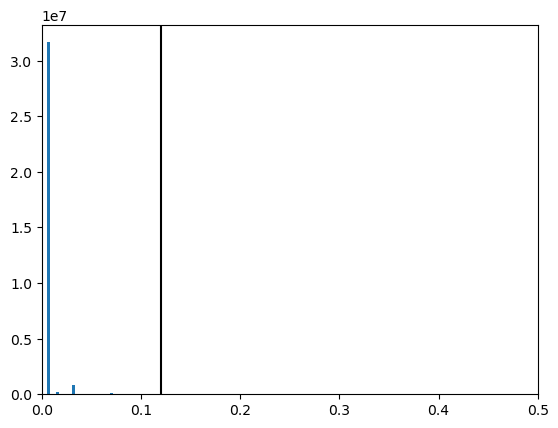

In [50]:
fig,ax = plt.subplots()
ax.hist(rem_df['rem_blink_score'],bins=200)
# ax.set_yscale('log')
ax.set_xlim(0,0.5)
ax.axvline(0.12,color='black')
# plt.show()

In [51]:

rem_df = rem_df[rem_df['rem_blink_score']>0.12]
print(rem_df.shape)

(155011, 3)


In [52]:
# df.to_csv(os.path.join(metadata_folder,'calibrated_parquet_files_with_metadata.tsv'), sep='\t',index=False)

In [53]:
p = wt.get_formula_props(node_data,formula_key='predicted_formula')
node_data = pd.merge(node_data,p,left_on='predicted_formula',right_on='formula',how='left')

In [54]:
if 'original_index' in node_data.columns:
    node_data.drop(columns=['original_index'],inplace=True)
node_data.index.name = 'original_index'
node_data.reset_index(inplace=True,drop=False)


In [55]:

# # Create the graph from the similarity matrix
G_draft = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_blink_score')
G_draft.remove_edges_from([(u, v) for u, v in G_draft.edges() if u == v])         
G_draft.remove_nodes_from(list(nx.isolates(G_draft)))

G = G_draft.copy()

drop_cols = """mdm_mz_vals
mdm_i_vals
original_mz_vals
original_i_vals
mdm_spectrum
original_spectrum"""
drop_cols = drop_cols.split('\n')
cols = list(set(node_data.columns) - set(drop_cols))
node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

nx.set_node_attributes(G, node_data_dict)



In [56]:

def make_mgf(output_filename,df,G,spectra_type='nl_spectrum'):
    cols = ['FEATURE_ID','SCANS','ORIGINAL_ID','PEPMASS','PRECURSOR_MZ','RTINSECONDS','CHARGE','MSLEVEL']
    temp = df[df.index.isin(G.nodes)].copy()
    temp.reset_index(inplace=True,drop=True)
    temp['FEATURE_ID'] = temp['original_index']
    temp['SCANS'] = temp.index.tolist() # probably needs +1
    temp['ORIGINAL_ID'] = temp['original_index']
    temp['CHARGE'] = '1-'
    temp['MSLEVEL'] = 2
    temp['RTINSECONDS'] = temp['rt']*60
    temp['PRECURSOR_MZ'] = temp['precursor_mz']
    temp['PEPMASS'] = temp['precursor_mz']

    spectra = []
    for i,row in temp.iterrows():
        spectra.append({'params':row[cols].to_dict(),
                        'm/z array':row[spectra_type][0],'intensity array':row[spectra_type][1]})
    mgf.write(spectra,output_filename)
    


make_mgf('../../data/envnet_mdm_spectra.mgf',node_data,G,spectra_type='mdm_spectrum')
make_mgf('../../data/envnet_original_spectra.mgf',node_data,G,spectra_type='original_spectrum')


In [57]:


smiles_col = 'smiles_identity'
# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
node_id = [k for k, v in identity_smiles.items() if isinstance(v,str)]
identity_smiles = [v for k, v in identity_smiles.items() if isinstance(v,str)]
df = pd.DataFrame(data=identity_smiles,columns=['smiles'])
df['node_id'] = node_id
df['mol'] = df['smiles'].apply(lambda x: MolFromSmiles(x) if x is not '' else None)
df['inchi_key'] = df['mol'].apply(lambda x: MolToInchiKey(x) if x is not None else None)

df

,smiles,node_id,mol,inchi_key
0,,2.0,None,None
1,,11.0,None,None
2,C/C(=C\C(=O)O)CC(=O)O,104.0,<rdkit.Chem.rdchem.Mol object at 0x7f2788162970>,WKRBKYFIJPGYQC-DUXPYHPUSA-N
3,,700.0,None,None
4,,891.0,None,None
...,...,...,...,...
15957,,16367.0,None,None
15958,,16368.0,None,None
15959,,16369.0,None,None
15960,,16370.0,None,None


In [58]:

url = "https://npclassifier.gnps2.org/classify"
df.reset_index(inplace=True,drop=True)
out = []
for i,row in df[pd.notna(df['inchi_key'])].iterrows(): # for some reason smiles is "" and not None
    # smiles = df.loc[0,'smiles_identity']
    r = requests.get(url, params={"smiles": row['smiles']})
    if r.status_code == 200:
        d = r.json()
    else:
        if 'C' in row['smiles']:
            print(row['smiles'])
        d = {'class_results': None,
                     'superclass_results': None,
                     'pathway_results': None,
                     'isglycoside': False}
    d['inchi_key'] = row['inchi_key']
    out.append(d)

In [59]:
out2 = pd.DataFrame(out)
cols = ['class_results', 'superclass_results', 'pathway_results']
for c in cols:
    out2[c] = out2[c].apply(lambda x: ','.join(sorted(x)) if isinstance(x,list) else '')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,WKRBKYFIJPGYQC-DUXPYHPUSA-N
1,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,WHBMMWSBFZVSSR-UHFFFAOYSA-N
2,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
3,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
4,,,Shikimates and Phenylpropanoids,False,GHMLBKRAJCXXBS-UHFFFAOYSA-N
...,...,...,...,...,...
830,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids,False,XHIZTTHXBFOZAS-LDYXHBNGSA-N
831,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N
832,Flavones,Flavonoids,Shikimates and Phenylpropanoids,False,HDUZOHKOFFWLBU-UHFFFAOYSA-N
833,Polyprenylated cyclic polyketides (Hop meroterpenoids),Meroterpenoids,"Polyketides,Terpenoids",False,QDKLRKZQSOQWJQ-SMDXAGPFSA-N


In [60]:
def replace_list_identifiers(df,identifier='class_results'):
    temp = df.loc[pd.notna(df[identifier]),identifier].tolist()
    temp = [x.split(',') for x in temp]
    temp = [item for sublist in temp for item in sublist]
    temp = pd.Series(temp)
    pathway_counts = temp.value_counts()
    for i,row in df[pd.notna(df[identifier])].iterrows():
        split_results = row[identifier].split(',')
        if len(split_results) > 1:
            d = {}
            for r in split_results:
                d[r] = pathway_counts[r]
            df.at[i, identifier] = max(d, key=d.get)

    return df

out2 = replace_list_identifiers(out2,identifier='class_results')
out2 = replace_list_identifiers(out2,identifier='pathway_results')
out2 = replace_list_identifiers(out2,identifier='superclass_results')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,WKRBKYFIJPGYQC-DUXPYHPUSA-N
1,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,WHBMMWSBFZVSSR-UHFFFAOYSA-N
2,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
3,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
4,,,Shikimates and Phenylpropanoids,False,GHMLBKRAJCXXBS-UHFFFAOYSA-N
...,...,...,...,...,...
830,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids,False,XHIZTTHXBFOZAS-LDYXHBNGSA-N
831,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N
832,Flavones,Flavonoids,Shikimates and Phenylpropanoids,False,HDUZOHKOFFWLBU-UHFFFAOYSA-N
833,Polyprenylated cyclic polyketides (Hop meroterpenoids),Meroterpenoids,Terpenoids,False,QDKLRKZQSOQWJQ-SMDXAGPFSA-N


In [61]:
df = pd.merge(df,out2,on='inchi_key',how='left')
df.reset_index(inplace=True,drop=True)
df

,smiles,node_id,mol,inchi_key,class_results,superclass_results,pathway_results,isglycoside
0,,2.0,None,None,NaN,NaN,NaN,NaN
1,,11.0,None,None,NaN,NaN,NaN,NaN
2,C/C(=C\C(=O)O)CC(=O)O,104.0,<rdkit.Chem.rdchem.Mol object at 0x7f2788162970>,WKRBKYFIJPGYQC-DUXPYHPUSA-N,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False
3,,700.0,None,None,NaN,NaN,NaN,NaN
4,,891.0,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
16169,,16367.0,None,None,NaN,NaN,NaN,NaN
16170,,16368.0,None,None,NaN,NaN,NaN,NaN
16171,,16369.0,None,None,NaN,NaN,NaN,NaN
16172,,16370.0,None,None,NaN,NaN,NaN,NaN


In [62]:
df.drop_duplicates(inplace=True)

In [63]:
for c in ['class_results', 'superclass_results', 'pathway_results']:
    nx.set_node_attributes(G, df.set_index('node_id')[c].fillna('').to_dict(), c)


In [64]:
nx.write_graphml(G,'../../data/envnet_noprop.graphml')
# G_filt = nx.maximum_spanning_tree(G)
# nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst_noprop.graphml')

In [65]:
11376/13053

0.8715237876350265

In [66]:
G = nx.read_graphml('../../data/envnet_noprop.graphml')
print(len(G.nodes),len(G.edges))
# main_column = 'pathway_results'
main_column = 'class_results'
all_columns = ['class_results', 'superclass_results', 'pathway_results']
df = G.nodes(data=True) 
df = pd.DataFrame(df, columns=['node_id', 'data'])
df.set_index('node_id', inplace=True)
df = df['data'].apply(pd.Series)
df.reset_index(inplace=True,drop=False)
df.head()

15962 147973


,node_id,experiment_id,h,n_to_c,mz_centroid_ms1,peak_height_ms1,ai,o_to_c,original_index,dbe_ai_mod,mass_error,h_to_c,p_to_c,isolated_precursor_mz,num_datapoints_ms1,num_mdm_frags,estimated_fdr,predicted_formula,predicted_mass,dbe,n,massive_basename,p,s,peak_area_ms1,nosc,formula,precursor_mz,o,c,coisolated_precursor_count,has_ccms_peak,precursor_mz_group,ai_mod,rt_peak_ms1,dbe_ai,rt,parquet,environmental,predicted_formula_mdm_identity,max_score_identity,original_p2d2_index_ref_identity,name_identity,ref_mdm_identity,best_match_method_identity,precursor_mz_ref_mdm_identity,name_ref_mdm_identity,formula_identity,original_index_query_identity,coisolated_precursor_count_query_identity,formula_ref_mdm_identity,original_p2d2_index_identity,max_matches_identity,precursor_mz_query_identity,inchi_key_ref_mdm_identity,smiles_identity,precursor_mz_mdm_identity,precursor_mz_identity,query_identity,inchi_key_identity,class_results,superclass_results,pathway_results,title_massive,massive_id,instrument_massive,description_massive,keywords_massive,dataset_massive,n_to_p,formula_ref_original_identity,name_ref_original_identity,predicted_formula_original_identity,inchi_key_ref_original_identity,ref_original_identity,precursor_mz_ref_original_identity,precursor_mz_original_identity
0,2.0,WAVEstab_20231017,2.0,2.0,88.981819,5171.739746,0.666667,1.000000,2,-1.5,0.000752,2.000000,0.0,89.024200,1.0,4,0.000000,CH2N2OS,88.981508,2.0,2.0,WAVEstab_20231017-20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_NEG_MS2_14_supern-WAVE-NatCom-NLDM-Day7_2_6uL_107,0.0,1.0,5.171740e+03,8.000000,CH2N2OS,88.982259,1.0,1.0,2,False,2,0.60,1.598022,-2.0,2.218232,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_NEG_MS2_14_supern-WAVE-NatCom-NLDM-Day7_2_6uL_107.parquet,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,FRCgw2_20230830,4.0,0.0,103.003427,64052.832031,2.000000,1.333333,11,0.0,0.000086,1.333333,0.0,102.948532,52.0,4,0.000000,C3H4O4,103.003683,2.0,0.0,FRCgw2_20230830-20230831_EB_MdR_101544-059_FRCgw2_20230830_EXP120A_C18-EP_USDAY72349_NEG_MS2_3_GW-MLSB5-16p1-SPE-2mL_1_ProfMaxRes6uL_15,0.0,0.0,1.759377e+06,1.333333,C3H4O4,103.003597,4.0,3.0,2,False,10,0.00,11.364225,-2.0,11.222493,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20230831_EB_MdR_101544-059_FRCgw2_20230830_EXP120A_C18-EP_USDAY72349_NEG_MS2_3_GW-MLSB5-16p1-SPE-2mL_1_ProfMaxRes6uL_15.parquet,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104.0,FRCgwater_20230105,8.0,0.0,143.034476,674496.437500,-0.500000,0.666667,104,1.0,0.000261,1.333333,0.0,143.034531,345.0,4,0.000000,C6H8O4,143.034983,3.0,0.0,FRCgwater_20230105-20230113_EB_MdR_101544-059_FRCgwater_20230105_EXP120A_C18-EP_USDAY72349_NEG_MS2_11_SRFA2-MeOH-fil-NA-NA_1__54,0.0,0.0,7.248491e+07,0.000000,C6H8O4,143.034722,4.0,6.0,1,False,77,0.25,0.928929,-1.0,1.153207,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20230113_EB_MdR_101544-059_FRCgwater_20230105_EXP120A_C18-EP_USDAY72349_NEG_MS2_11_SRFA2-MeOH-fil-NA-NA_1__54.parquet,True,C6H8O4,1.093338,176355.0,3-Methylglutaconic acid - 40.0 eV M-H,25576.0,score_mdm,143.035,3-Methylglutaconic acid - 40.0 eV M-H,C6H8O4,603019.0,1.0,C6H8O4,176355.0,5.0,143.034722,WKRBKYFIJPGYQC-DUXPYHPUSA-N,C/C(=C\C(=O)O)CC(=O)O,143.034722,143.035,545.0,WKRBKYFIJPGYQC-DUXPYHPUSA-N,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,700.0,DOM-TargetedMS2_pilot1,4.0,0.0,178.983051,6528.469727,1.250000,2.000000,700,-1.0,0.000068,1.000000,0.0,178.977783,14.0,6,0.004658,C4H4O8,178.983341,3.0,0.0,DOM-TargetedMS2_pilot1-20231005_JGI_TH_Internal_DOM-TargetedMS2_pilot1_EXP120B_C18_USDAY81385_N

In [67]:

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# subclass_name = []
# iks = df.loc[pd.notna(df['inchi_key']),'inchi_key'].unique()
# for ik in iks:
#     f = '%s.json'%ik
#     f = os.path.join(classyfire_dir,f)
#     with open(f,'r') as fid:
#         cf = fid.read()
#     cf = json.loads(cf.strip())
#     if isinstance(cf,str):
#         cf = json.loads(cf)
#     # cf_json = json.dumps(cf)
#     if not main_column in cf:
#         cf[main_column] = {'name':None}
#     if not 'superclass' in cf:
#         cf['superclass'] = {'name':None}
#         cf['class'] = {'name':None}
#     if cf[main_column] is None:
#         cf[main_column] = {'name':None}
#     superclass_name.append(cf['superclass']['name'])
#     class_name.append(cf['class']['name'])
#     subclass_name.append(cf[main_column]['name'])

# temp = pd.DataFrame(index=iks)
# temp['superclass'] = superclass_name
# temp['class'] = class_name
# temp[main_column] = subclass_name

# df = pd.merge(df,temp,left_on='inchi_key',right_index=True,how='left')

# df

In [68]:
df.loc[df['node_id']=='41.0',all_columns]

,class_results,superclass_results,pathway_results


In [69]:

def min_additional_subgraph(graph, original_nodes,radius=1,min_count=0):
    nodes = []
    for node in original_nodes:
        # Create an ego graph centered at the current node
        
        ego_subgraph = nx.ego_graph(graph, node,radius=radius)
        nodes.extend(list(ego_subgraph.nodes))
    df = pd.DataFrame(data=nodes,columns=['nodes'])
    df = df.groupby('nodes').filter(lambda x: len(x) >= min_count)
    nodes = df['nodes'].tolist() + original_nodes
    
    nodes = list(set(nodes))
    nodes = sorted(nodes)
    return nodes

sc_df = pd.DataFrame()
sc_df['node_id'] = df['node_id'].values
sc_df[main_column] = df[main_column].values
for class_name in sc_df.loc[pd.notna(sc_df[main_column]),main_column].unique():
    idx = sc_df[main_column]==class_name
    original_nodes = sc_df.loc[idx,'node_id'].tolist()
    new_nodes = min_additional_subgraph(G, original_nodes,radius=2,min_count=3)
    sc_df[class_name] = False
    # idx = sc_df['node_id'].isin(original_nodes)
    # sc_df.loc[idx,class_name] = True
    idx = sc_df['node_id'].isin(new_nodes)
    sc_df.loc[idx,class_name] = True
sc_df.set_index('node_id',inplace=True)
sc_df.drop(columns=[main_column],inplace=True)
sc_df
# For each row in the DataFrame
# If the sum of the row is greater than 1
# Find the class with the highest frequency
# Set all other classes to False

,Dicarboxylic acids,Hydroxy fatty acids,4-pyrone derivatives,Unsaturated fatty acids,Simple phenolic acids,Wax monoesters,Simple coumarins,Cinnamic acids and derivatives,Menthane monoterpenoids,Shikimic acids and derivatives,Acyclic monoterpenoids,Aminoacids,Dipeptides,Branched fatty acids,Arylnaphthalene and aryltetralin lignans,Monosaccharides,Phenanthrenes,Catechols with side chains,Pyridine alkaloids,Camphane monoterpenoids,Oxo fatty acids,Phthalide derivatives,Open-chain polyketides,Isocoumarins,Jasmonic acids,Simple cyclic polyketides,p-Terphenyls,Acridone alkaloids,Quinazoline alkaloids,Sorbicilinoids,Quinoline alkaloids,Naphthoquinones,Cyclitols,Flavones,Phenylethanoids,Monomeric stilbenes,Plant xanthones,Azaphilones,Iridoids monoterpenoids,Prenyl quinone meroterpenoids,Simple indole alkaloids,Fatty alcohols,Chromones,Quadrane sesquiterpenoids,pteridine alkaloids,Acyl phloroglucinols,Anthraquinones and anthrones,Methyl xanthones,Fungal DPEs,Flavanones,Humulane sesquiterpenoids,Isoindole alkaloids,Flavonols,Phenazine alkaloids,Eudesmane sesquiterpenoids,Pulvinones,Chalcones,Pyrrolidine alkaloids,Pyranocoumarins,Apocarotenoids(ε-),Zearalenones,12-oxophytodienoic acid metabolites,Macrolide lactones,Iphionane sesquiterpenoids,Cadinane sesquiterpenoids,Heterocyclic fatty acids,Isoflavones,Furans,Podocarpane diterpenoids,Dihydroflavonols,Guaiane sesquiterpenoids,2-pyrone derivatives,Neolignans,Phenylalanine-derived alkaloids,Gallotannins,Aurones,Gibberellins,Flavan-3-ols,Picrotoxane sesquiterpenoids,Dibenzylbutyrolactone lignans,Depsidones,Pterocarpan,N-acyl amines,Isoflavanones,Bisabolane sesquiterpenoids,Other Octadecanoids,Linear diarylheptanoids,Estrane steroids,Pimarane and Isopimarane diterpenoids,Cembrane diterpenoids,Prostaglandins,Paraconic acids and derivatives,Germacrane sesquiterpenoids,Angucyclines,Colensane and Clerodane diterpenoids,Abietane diterpenoids,Dibenzylbutane lignans,Pseudoguaiane sesquiterpenoids,Coumestan,Cannabinoids,Prezizaane sesquiterpenoids,Phytoprostanes,Abeoabietane diterpenoids,Hydroxy-hydroperoxyeicosapentaenoic acids,Hydroxy-hydroperoxyeicosatetraenoic acids,Hydroxy-hydroperoxyeicosatrienoic acids,Labdane diterpenoids,Nitro fatty acids,Miscellaneous apocarotenoids,Phenylethylamines,Phytofurans,Other Docosanoids,Furanoid lignans,Pregnane steroids,Arteminisin,Leukotrienes,Androstane steroids,Isoquinoline alkaloids,Usnic acid and derivatives,Maresins,Resolvin Ds,Serrulatane and Biflorane diterpenoids,Isoprostanes,Grayanotoxane diterpenoids,Furofuranoid lignans,Daucane sesquiterpenoids,Cardenolides,Thromboxanes,Kaurane and Phyllocladane diterpenoids,Diarylether type diarylheptanoids,Depsides,Cholane steroids,Pachydictyane diterpenoids,Tetraketide meroterpenoids,Cholestane steroids,3-Decalinoyltetramic acids,Oligomeric stibenes,Ansa macrolides,Oleanane triterpenoids,Farnesane sesquiterpenoids,Lupane triterpenoids,Erythromycins,Lanostane,Ursane and Taraxastane triterpenoids,Fusidane triterpenoids,Polyprenylated cyclic polyketides (Hop meroterpenoids)
node_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [70]:
# for columns with more than one True value, get the regional value_counts from an ego graph of radius 5 and replace with the most common value
for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
    ego_subgraph = nx.ego_graph(G, i,radius=1) #was 5
    nodes = list(ego_subgraph.nodes)
    temp = sc_df.loc[nodes]
    temp = temp.sum()
    temp = temp[temp>0]
    if len(temp)>0:
        most_common_class = temp.idxmax()
        sc_df.loc[i] = False
        sc_df.loc[i,most_common_class] = True



In [71]:
# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# # for nodes that are in more than one class, only keep the most abundant class
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     # get the most commonly occuring class
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     # get the indices of all the assigned classes
#     idx = row[row==True].index
#     # drop all but the most common
#     idx = idx[idx!=keep_class]
#     # zero them out
#     sc_df.loc[i,idx] = False

In [72]:
# for any class that has an ID in the original, reset it back to its original state
for i,row in df.iterrows():
    if pd.notna(row[main_column]):
        sc_df.loc[row['node_id'],:] = False
        sc_df.loc[row['node_id'],row[main_column]] = True


# recomute the ranked frequency now that ambiguous classes have been resolved
ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [73]:
cols = sc_df.columns
sc_df = sc_df.reset_index().melt(id_vars='node_id',value_vars=cols)
idx = sc_df['value']==True
sc_df = sc_df[idx]
sc_df = sc_df[pd.notna(sc_df['variable'])]
sc_df


,node_id,variable,value
2,104.0,Dicarboxylic acids,True
12,225.0,Dicarboxylic acids,True
18,2092.0,Dicarboxylic acids,True
24,89.0,Dicarboxylic acids,True
31,1302.0,Dicarboxylic acids,True
...,...,...,...
2297583,15539.0,Ursane and Taraxastane triterpenoids,True
2297699,15279.0,Ursane and Taraxastane triterpenoids,True
2297716,15300.0,Ursane and Taraxastane triterpenoids,True
2313512,14988.0,Fusidane triterpenoids,True


In [74]:
sc_df.value_counts('variable').head(40)

variable
Simple coumarins                        855
Zearalenones                            760
Gibberellins                            535
Cinnamic acids and derivatives          479
Simple phenolic acids                   419
Aminoacids                              337
Dicarboxylic acids                      316
Abietane diterpenoids                   307
Tetraketide meroterpenoids              279
Chalcones                               227
Anthraquinones and anthrones            173
Prostaglandins                          146
Flavonols                                73
Oleanane triterpenoids                   61
Flavones                                 54
Cannabinoids                             51
Cholane steroids                         49
Flavanones                               42
Isoflavones                              32
Hydroxy fatty acids                      27
Cadinane sesquiterpenoids                25
Other Octadecanoids                      23
Neolignans             

In [75]:
sc_df

,node_id,variable,value
2,104.0,Dicarboxylic acids,True
12,225.0,Dicarboxylic acids,True
18,2092.0,Dicarboxylic acids,True
24,89.0,Dicarboxylic acids,True
31,1302.0,Dicarboxylic acids,True
...,...,...,...
2297583,15539.0,Ursane and Taraxastane triterpenoids,True
2297699,15279.0,Ursane and Taraxastane triterpenoids,True
2297716,15300.0,Ursane and Taraxastane triterpenoids,True
2313512,14988.0,Fusidane triterpenoids,True


In [76]:
# Add cluster labels to graph
cluster_dict = sc_df.copy()
cluster_dict.rename(columns={'variable':'structural_cluster_subclassname'},inplace=True)
print(cluster_dict.shape)
if main_column != 'pathway_results':
    cluster_dict = pd.merge(df[all_columns].drop_duplicates(main_column),cluster_dict,left_on=main_column,right_on='structural_cluster_subclassname',how='right')
else:
    cluster_dict[main_column] = cluster_dict['structural_cluster_subclassname']

cluster_dict.drop(columns=['structural_cluster_subclassname','value'],inplace=True)
cluster_dict.drop_duplicates('node_id',inplace=True)
cluster_dict.set_index('node_id',inplace=True)
cluster_dict.fillna('',inplace=True)
cluster_dict = cluster_dict.add_suffix('_propagated')

cluster_dict

(5685, 3)


,class_results_propagated,superclass_results_propagated,pathway_results_propagated
node_id,,,
104.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
225.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
2092.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
89.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
1302.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
...,...,...,...
15539.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids
15279.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids
15300.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids


In [77]:
print(cluster_dict.shape)
# need to understand why there are duplicates

cluster_dict = cluster_dict.to_dict(orient='index')

nx.set_node_attributes(G, cluster_dict)
# cluster_dict
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# len(clusters),len(set(clusters))

(5685, 3)


In [78]:
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)
df.value_counts('pathway_results')

pathway_results
Shikimates and Phenylpropanoids    293
Fatty acids                        159
Terpenoids                         155
Polyketides                         94
Alkaloids                           48
Amino acids and Peptides            34
Carbohydrates                        7
dtype: int64

In [79]:
df.value_counts('pathway_results_propagated')

pathway_results_propagated
Shikimates and Phenylpropanoids    2297
Terpenoids                         1362
Polyketides                        1057
Fatty acids                         580
Amino acids and Peptides            344
Alkaloids                            28
Carbohydrates                        17
dtype: int64

In [80]:
# df = G.nodes(data=True)
# df = pd.DataFrame(df)
# df.columns = ['node','data']
# df['data'] = df['data'].apply(lambda x: dict(x))
# df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
# df.reset_index(inplace=True,drop=True)
# df['consensus_class'] = None

# # Count the number of occurrences of each subclass
# subclass_counts = df[main_column].value_counts()

# # Get the subclasses that have at least 100 values
# large_subclasses = subclass_counts[subclass_counts >= 100].index

# # Set the consensus_class for large subclasses
# df.loc[df[main_column].isin(large_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(large_subclasses), main_column]

# # Get the subclasses that have less than 100 values
# small_subclasses = subclass_counts[subclass_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df[main_column].isin(small_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(small_subclasses), 'class']

# # Get the subclasses that have less than 100 values
# class_counts = df['consensus_class'].value_counts()
# small_classes = class_counts[class_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

# df = df[['node','consensus_class']]

# df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

# df.fillna('',inplace=True)
# df.value_counts('consensus_class')
# nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


In [81]:
# import os
# import networkx as nx
# from pathlib import Path
# try:
#     module_path = os.path.join(Path(__file__).parents[2])
# except: # Jupyter notebook probably
#     module_path = os.path.join(os.getcwd(), '../../')
# graphml_file = os.path.join(module_path, 'data/CarbonNetwork.graphml')
# G = nx.read_graphml(graphml_file)


In [82]:
# # Get the connected components in the graph
def filter_subgraphs(G,min_size=100):
    components = list(nx.connected_components(G))

    # # Filter out subgraphs with less than 1000 nodes
    filtered_components = [component for component in components if len(component) >= min_size]

    # # Create a new graph
    G_filtered = nx.Graph()

    # # Add each subgraph to the new graph
    for component in filtered_components:
        G_filtered = nx.compose(G_filtered, G.subgraph(component))
    return G_filtered

G = filter_subgraphs(G)

In [83]:
# nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork.graphml')
# G_filt = nx.maximum_spanning_tree(G)
# nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst.graphml')
print('nodes',len(G.nodes))
print('edges',len(G.edges))

nx.write_graphml(G,'../../data/envnet.graphml')

# get the edge data from T and store it as a data from with "source" and "target" and "weight" attributes
edge_data = nx.to_pandas_edgelist(G)
edge_data['source'] = edge_data['source'].astype(float).astype(int)
edge_data['target'] = edge_data['target'].astype(float).astype(int)
edge_data = edge_data[['source','target']]
edge_data.to_csv('../../data/edge_data.csv',index=None)

# get the node data from T and store it as a data from with "node" and "data" attributes
node_data = G.nodes(data=True)
node_data = pd.DataFrame(node_data)
node_data.columns = ['node','data']
node_data['data'] = node_data['data'].apply(lambda x: dict(x))
node_data = pd.concat([node_data.drop(['data'], axis=1), node_data['data'].apply(pd.Series)], axis=1)
node_data.to_csv('../../data/node_data.csv',index=None)

# https://cosmograph.app/run/?data=https://raw.githubusercontent.com/benbowen/thoughts/master/edge_data.csv



nodes 15924
edges 147953


In [84]:
idx1 = node_data['massive_basename'].str.startswith('MSV')
node_data.loc[idx1,'massive_basename'].nunique(),node_data.loc[~idx1,'massive_basename'].nunique()

(871, 347)

In [1]:


# import networkx as nx
# graphml_file = '../../data/envnet.graphml'
# G = nx.read_graphml(graphml_file)
# # do it like this
# # pos = graphviz_layout(G, prog='dot', root=0, args='-Grankdir="LR"')

# alg = 'neato'
# pos = nx.nx_agraph.graphviz_layout(G, prog=alg)#,args='-Goverlap="scale"')
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="False"') #blob
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="vpsc"') #crashes
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="orthoxy"') #looks like a lightning bolt
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="ipsep"') #looks like 

# for node, (x, y) in pos.items():
#     G.nodes[node]['x'] = x
#     G.nodes[node]['y'] = y

# nx.write_graphml(G, graphml_file.replace('.graphml', '_with-positions.graphml'))


In [85]:
# # Create a maximum spanning tree from G
# T = nx.maximum_spanning_tree(G, weight='rem_blink_score')

# # Get the list of edges in G sorted by weight in descending order
# edges_sorted_by_weight = sorted(G.edges(data=True), key=lambda x: x[2]['rem_blink_score'], reverse=True)
# max_degree = 3
# # Add edges back to the tree from the original network until there are 30000 edges total in the network
# for u, v, data in edges_sorted_by_weight:
#     if T.number_of_edges() >= 350000:
#         break
#     # check the degree of the nodes
#     if T.degree(u) > max_degree:
#         continue
#     if T.degree(v) > max_degree:
#         continue
#     if not T.has_edge(u, v):
#         T.add_edge(u, v, **data)
    

# print('nodes', len(T.nodes))
# print('edges', len(T.edges))

# # G.remove_nodes_from(list(nx.isolates(G)))
# # k = 5  # replace with your desired k

# # from blink.utils import filter_top_k
# # # filter_top_k(G, top_k=k, edge_score='rem_blink_score')



# # drop_cols = """mdm_mz_vals
# # mdm_i_vals
# # original_mz_vals
# # original_i_vals
# # mdm_spectrum
# # original_spectrum"""
# # drop_cols = drop_cols.split('\n')
# # cols = list(set(node_data.columns) - set(drop_cols))

# # node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

# # nx.set_node_attributes(T, node_data_dict)
# # # Remove self-loops
# # Remove isolates
# T.remove_nodes_from(list(nx.isolates(T)))
# print('nodes',len(T.nodes))
# print('edges',len(T.edges))
# nx.write_graphml(T,'../../data/CarbonNetwork.graphml')
# # nx.write_graphml(G,'CarbonNetwork.graphml')


In [86]:
# edges_sorted_by_weight[40000]

In [87]:

# this will stop the run
# # import networkx as nx

# # # Get the connected components in the graph
# components = list(nx.connected_components(G))

# # # Filter out subgraphs with less than 1000 nodes
# filtered_components = [component for component in components if len(component) >= 1000]

# # # Create a new graph
# G_filtered = nx.Graph()

# # # Add each subgraph to the new graph
# for component in filtered_components:
#     G_filtered = nx.compose(G_filtered, G.subgraph(component))
    
# # alg = 'sfdp'

# # do it like this
# # pos = graphviz_layout(G, prog='dot', root=0, args='-Grankdir="LR"')

# alg = 'neato'
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="scale"')
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="False"') #blob
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="vpsc"') #crashes
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="orthoxy"') #looks like a lightning bolt
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="ipsep"') #looks like 
# ipsep

# for node, (x, y) in pos.items():
#     G_filtered.nodes[node]['x'] = x
#     G_filtered.nodes[node]['y'] = y

# nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions.graphml'))


In [88]:
# import matplotlib.pyplot as plt
# nx.draw(G_filtered, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=3)

# plt.show()

In [89]:
# # remove node overlaps
# pos = nx.kamada_kawai_layout(G_filtered)
# for node, (x, y) in pos.items():
#     G_filtered.nodes[node]['x'] = x
#     G_filtered.nodes[node]['y'] = y
# nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions_kamada-kawai.graphml'))